In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from arch import arch_model
import mgarch
from datetime import date
from joblib import Parallel, delayed
from matplotlib import pyplot as plt

In [2]:
Bank_data = pd.read_csv("Bank_data_full_2.csv")
Bank_data = Bank_data.drop(['PERMNO','PERMCO'], axis = 1)

Bank_data_other = pd.read_csv("Bank_data_full_2.csv")
Bank_data_other = Bank_data_other.drop(['PERMNO','PERMCO'], axis = 1)



SP_index = pd.read_csv("SP_500_Data.csv")
sector_data = pd.read_csv("48_Industry_Portfolios_Daily.csv")
sector_data = sector_data.rename(columns={sector_data.columns[0]:'Date'})
sector_data.head()

sector_data.iloc[:, 0] = pd.to_datetime(sector_data.iloc[:, 0].astype(str), format='%Y%m%d', errors='coerce')

sector_data = sector_data[['Date','Aero', 'Guns', 'Ships','Oil', 'Coal', 'Util']].copy()

sector_data = sector_data.loc[:26132]




C:\Users\Coco\AppData\Local\Temp\ipykernel_23064\2074775263.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Bank_data = pd.read_csv("Bank_data_full_2.csv")
C:\Users\Coco\AppData\Local\Temp\ipykernel_23064\2074775263.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Bank_data_other = pd.read_csv("Bank_data_full_2.csv")
C:\Users\Coco\AppData\Local\Temp\ipykernel_23064\2074775263.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sector_data = pd.read_csv("48_Industry_Portfolios_Daily.csv")


In [3]:
Bank_data_other['Market_Cap'] = Bank_data_other['PRC'].values*Bank_data_other['SHROUT'].values


In [4]:
sector_data.set_index('Date', inplace=True)

c:\Users\Coco\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [5]:
sector_data = sector_data.sort_index()
sector_data = sector_data[ (sector_data.index >= '2000-01-03') & (sector_data.index <= '2024-12-31') ].copy()


In [6]:

SP_index = SP_index.rename(columns={'caldt':'Date','sprtrn': 'Ret'})

SP_index.set_index('Date', inplace=True)

In [7]:
SP_index = SP_index.sort_index()

SP_index = SP_index[ (SP_index.index >= '2000-01-03') & (SP_index.index <= '2024-12-31') ].copy()

In [8]:
sector_data = sector_data.apply(pd.to_numeric, errors='coerce')

In [9]:
Defence_index = pd.DataFrame()
Energy_index = pd.DataFrame()

Defence_index = 1/3*sector_data['Aero'].values+1/3*sector_data['Guns'].values+1/3*sector_data['Ships'].values
Energy_index = 1/3*sector_data['Oil'].values+1/3*sector_data['Coal'].values+1/3*sector_data['Util'].values

In [10]:
Defence_index  = pd.DataFrame(Defence_index, index = sector_data.index)

Energy_index = pd.DataFrame(Energy_index,index=sector_data.index)

Defence_index = Defence_index
Energy_index = Energy_index
Energy_index.head()

,0
Date,
2000-01-03,-0.773333
2000-01-04,-2.586667
2000-01-05,1.183333
2000-01-06,0.460000
2000-01-07,1.623333


In [11]:
SP_index.columns

Index(['Ret'], dtype='object')

In [12]:
Geo_Pol_long = pd.DataFrame()
Geo_Pol_short = pd.DataFrame()
Geo_Pol_index = pd.DataFrame()

Geo_Pol_long = 0.5*Defence_index.values+0.5*Energy_index.values # in percentage
Geo_Pol_long = pd.DataFrame(Geo_Pol_long, index = Energy_index.index)

Geo_Pol_short = -SP_index.values*100 # from decimal to percentage


In [13]:
Geo_Pol_index = Geo_Pol_long+Geo_Pol_short


In [70]:
SP_index

,Ret
Date,
2000-01-03,-0.009549
2000-01-04,-0.038345
2000-01-05,0.001922
2000-01-06,0.000956
2000-01-07,0.027090
...,...
2024-12-24,0.011043
2024-12-26,-0.000406
2024-12-27,-0.011056


In [71]:
Defence_index

,0
Date,
2000-01-03,-4.896667
2000-01-04,0.820000
2000-01-05,2.260000
2000-01-06,0.963333
2000-01-07,1.910000
...,...
2024-12-24,0.966667
2024-12-26,0.310000
2024-12-27,-0.806667


In [57]:
print(Geo_Pol_index)

                   0
Date                
2000-01-03 -1.880100
2000-01-04  2.951167
2000-01-05  1.529467
2000-01-06  0.616067
2000-01-07 -0.942333
...              ...
2024-12-24 -0.517633
2024-12-26  0.042267
2024-12-27  0.602267
2024-12-30  0.971867
2024-12-31  0.548500

[6289 rows x 1 columns]


ConversionError: Failed to convert value(s) to axis units: Timestamp('2008-09-15 00:00:00')

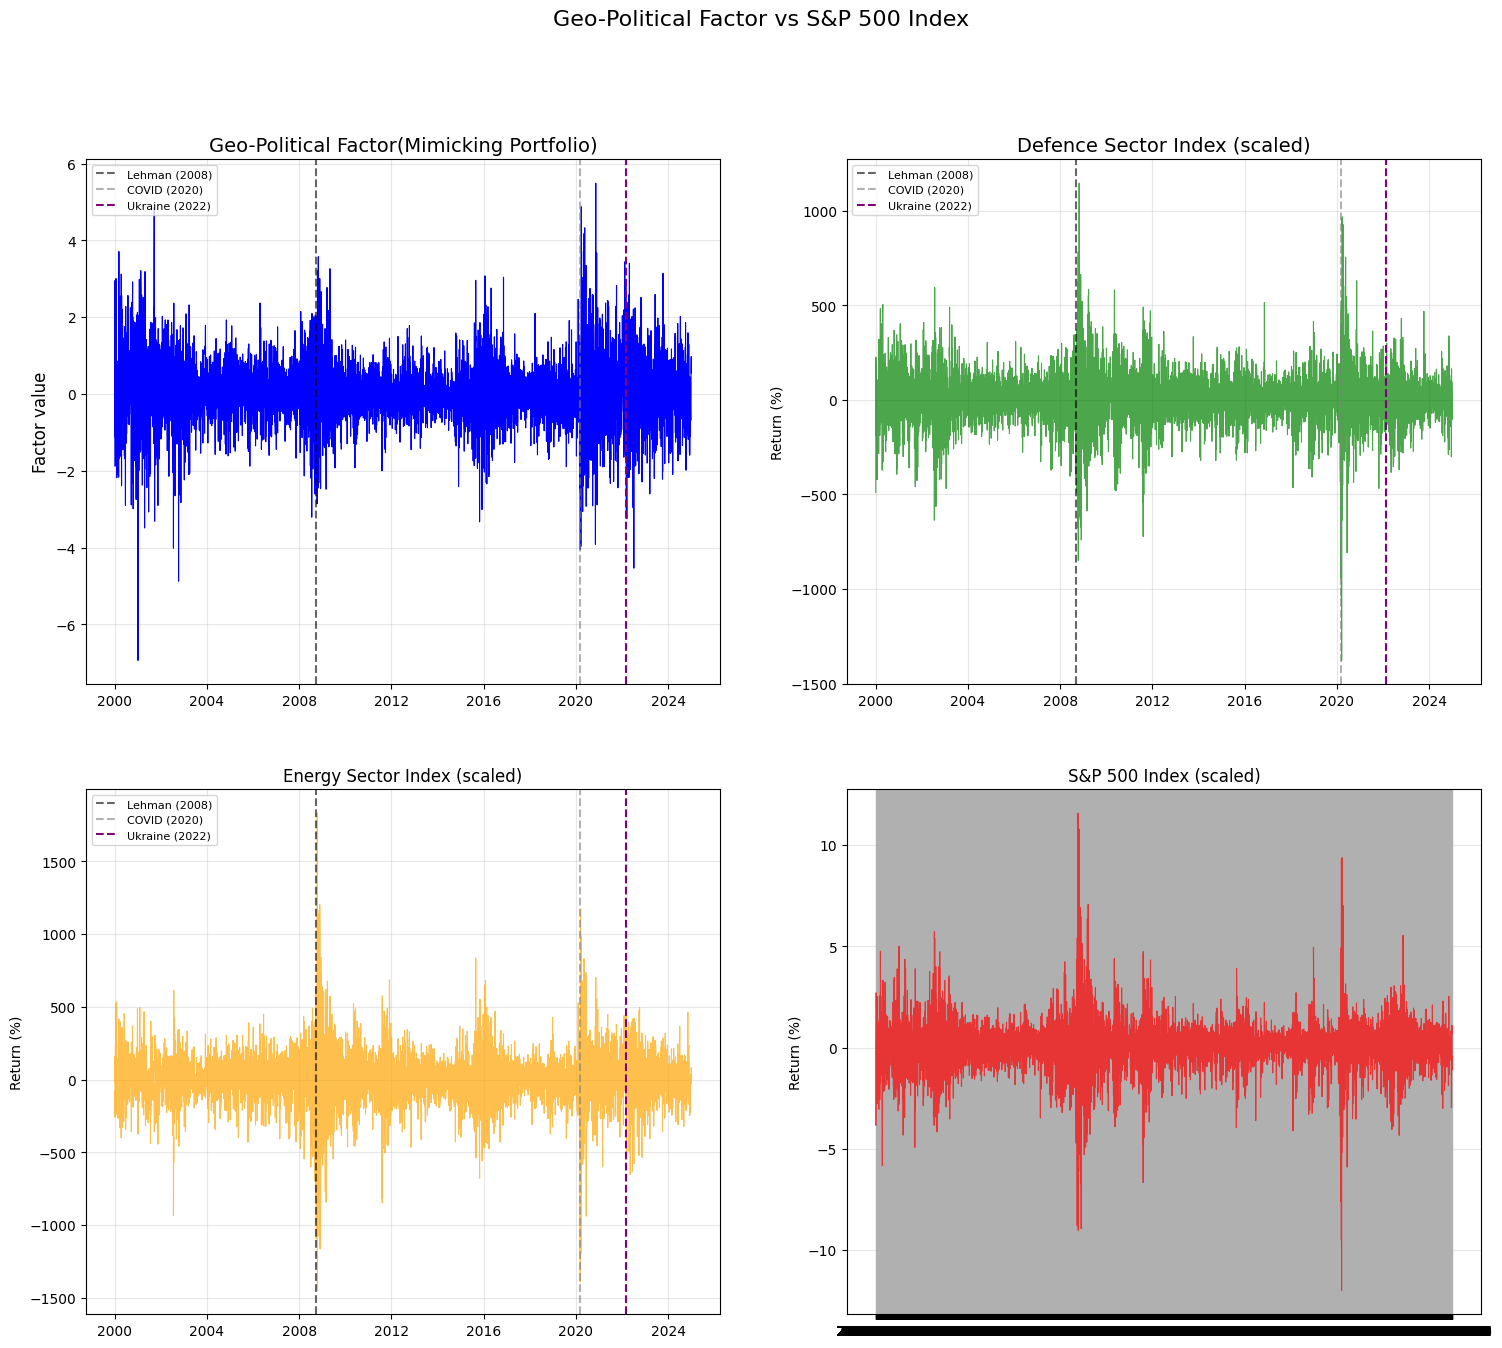

In [80]:
# Important dates
lehman = pd.to_datetime('2008-09-15')
covid = pd.to_datetime('2020-03-11')
ukraine = pd.to_datetime('2022-02-24')



# Plot Geo_Pol_index vs SP_index vs Defence_index vs Energy_index
fig,axes = plt.subplots(2,2, figsize=(18,15))
fig.suptitle('Geo-Political Factor vs S&P 500 Index', fontsize=16)
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(Geo_Pol_index, color='blue', linewidth=0.8)
ax1.set_title('Geo-Political Factor(Mimicking Portfolio)', fontsize=14)
ax1.set_ylabel('Factor value', fontsize=12)

ax2.plot(Defence_index*100, color='green', alpha=0.7, linewidth=0.8)
ax2.set_title('Defence Sector Index (scaled)', fontsize=14)
ax2.set_ylabel('Return (%)', #fontsize=12
               )

ax3.plot(Energy_index*100, color='orange', alpha=0.7, linewidth=0.8)
ax3.set_title('Energy Sector Index (scaled)', #fontsize=14
              )
ax3.set_ylabel('Return (%)')

ax4.plot(SP_index*100, color='red', alpha=0.7, linewidth=0.8)
ax4.set_title('S&P 500 Index (scaled)', 
              #fontsize=14
              )
ax4.set_ylabel('Return (%)')

for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(True, alpha=0.3)
    # Add vertical lines
    ax.axvline(lehman, color='black', linestyle='--', alpha=0.6, label='Lehman (2008)')
    ax.axvline(covid, color='gray', linestyle='--', alpha=0.6, label='COVID (2020)')
    ax.axvline(ukraine, color='purple', linestyle='--', linewidth=1.5, label='Ukraine (2022)')
    # Add Legend
    ax.legend(loc='upper left', fontsize=8)
plt.show()

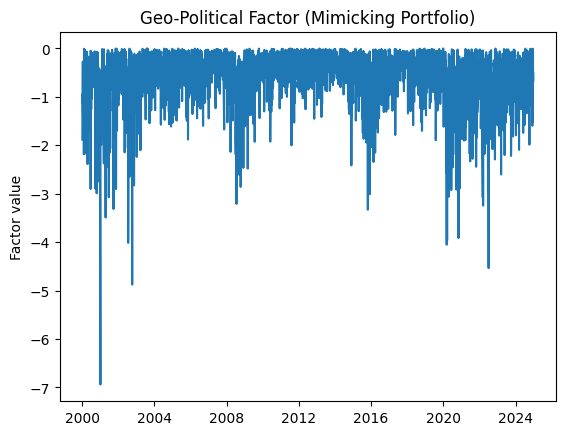

In [99]:
plt.plot(Geo_Pol_index[0].loc[Geo_Pol_index[0]<= 0 ])
plt.title('Geo-Political Factor (Mimicking Portfolio)')
plt.ylabel('Factor value')

plt.show()

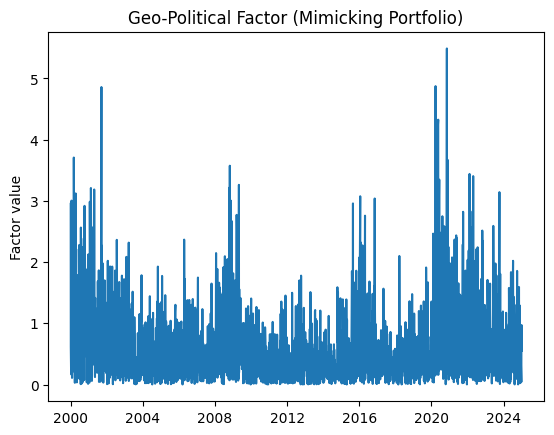

In [98]:
plt.plot(Geo_Pol_index[0].loc[Geo_Pol_index[0]>= 0 ])
plt.title('Geo-Political Factor (Mimicking Portfolio)')
plt.ylabel('Factor value')

plt.show()

In [14]:
Bank_data['date'] = pd.to_datetime(Bank_data['date'])
Bank_data.set_index('date', inplace=True)

In [15]:
Bank_data_other['date'] = pd.to_datetime(Bank_data_other['date'])
Bank_data_other.set_index('date', inplace=True)

In [16]:
Bank_data= Bank_data.sort_index()

Bank_data = Bank_data[ (Bank_data.index >= '2000-01-03') & (Bank_data.index <= '2024-12-31') ].copy()

In [17]:
Bank_data_other = Bank_data_other.sort_index()

Bank_data_other = Bank_data_other[ (Bank_data_other.index >= '2000-01-03') & (Bank_data_other.index <= '2024-12-31') ].copy()

In [18]:

Bank_data = {ticker: group for ticker, group in Bank_data.groupby('TICKER')}

In [19]:

Bank_data_other = {ticker: group for ticker, group in Bank_data_other.groupby('TICKER')}


In [20]:
X = np.column_stack([SP_index.values, Geo_Pol_index.values])
X = sm.add_constant(X)


results = {}




In [21]:
for ticker,y in Bank_data.items():

    if len(y)==len(SP_index):

        ys = y['RET'].astype(float).values
        X_ = X.astype(float)
        model = sm.OLS(ys, X).fit()
        results[ticker] = model





In [22]:
market_caps = [np.mean(y['Market_Cap']) for y in Bank_data_other.values()]
threshold = np.percentile(market_caps, 90)
print("Market Cap threshold for top 10% banks:", threshold)

Market Cap threshold for top 10% banks: 4651892.915935034


In [23]:
results_other = {}
for ticker,y in Bank_data_other.items():
    if len(y)==len(SP_index)and np.mean(y['Market_Cap'])>threshold:
        ys = y['RET'].astype(float).values
        X_ = X.astype(float)
        model = sm.OLS(ys, X_).fit()
        results_other[ticker] = model

In [24]:
neg_x2 = {}

x2_idx = 2
for ticker, model in results.items():

    x2_coef = model.params[x2_idx]
    x2_tval = model.tvalues[x2_idx]

    if x2_coef < 0 and np.abs(x2_tval) > 2 :
        neg_x2[ticker] = {
            'x2_coef': x2_coef,
            'x2_tvalue': x2_tval,
            'results': model.summary()
        }

for ticker, vals in neg_x2.items():
    print(ticker, vals['x2_coef'], vals['x2_tvalue'],'\n', vals['results'])

In [25]:
neg_x2_other = {}

for ticker, model in results_other.items():

    x2_coef = model.params[x2_idx]
    x2_tval = model.tvalues[x2_idx]

    if x2_coef < 0 and np.abs(x2_tval) > 2 :
        neg_x2_other[ticker] = {
            'x2_coef': x2_coef,
            'x2_tvalue': x2_tval
        }

for ticker, vals in neg_x2_other.items():
    print(ticker, vals['x2_coef'], vals['x2_tvalue'])

# Prepare Exog neg returns Indicator 

In [26]:
r_minus = [i if i < 0 else 0 for i in SP_index['Ret']]

# Prepare GPR index from monthly data (test instead of current index)

In [27]:
# create gpr_t_index_monthly by taking only the month columnn and GPRT column from gpr_data
gpr_data = pd.read_csv("data_gpr_export.csv")
gpr_data['Date'] = pd.to_datetime(gpr_data['month'], format='%d/%m/%Y')
gpr_t_index_monthly = gpr_data[['Date', 'GPRT']].copy()
gpr_t_index_monthly.set_index('Date', inplace=True)

In [28]:
gpr_t_index_monthly = gpr_t_index_monthly[
    (gpr_t_index_monthly.index >= '1999-12-01') & 
    (gpr_t_index_monthly.index <= '2010-01-31')    
]

In [29]:
# interpolate monthly data to daily data 
gpr_t_index_daily = gpr_t_index_monthly.resample('D').ffill()

In [30]:
# match gpr dates to SP_index dates
gpr_t_index_daily = gpr_t_index_daily.loc[gpr_t_index_daily.index.isin(SP_index.index)]

C:\Users\Coco\AppData\Local\Temp\ipykernel_23064\726057541.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  gpr_t_index_daily = gpr_t_index_daily.loc[gpr_t_index_daily.index.isin(SP_index.index)]


In [31]:
gpr_t_index_daily['GPRT_change'] = gpr_t_index_daily['GPRT'].diff().fillna(0)
gpr_t_index_daily.head()

,GPRT,GPRT_change
Date,,
2000-01-03,65.57,0.0
2000-01-04,65.57,0.0
2000-01-05,65.57,0.0
2000-01-06,65.57,0.0
2000-01-07,65.57,0.0


# Prepare log returns + scaling

In [32]:
# scaling 
scale_i = 100  # log(1+r)*10 ≈ r*10
scale_mkt = 1  # S&P 500 return without scaling
scale_r_m = 100 # negative market return *100
# scale_g = 100 


In [33]:
# data prep 

for ticker ,y in Bank_data_other.items():
    y['RET'] = pd.to_numeric(y['RET'], errors='coerce')
    y['RET'] = y['RET'].interpolate(method='linear', limit=2) 
    y['RET'] = y['RET'].fillna(0.0)
    y['logRET'] = np.log1p((y['RET'].copy()).astype(float).values)
    y['logRET'] = y['logRET']*scale_i
    Bank_data[ticker]['logRET'] = y['logRET']

# DCB 

In [34]:

Bank_data_filtered = { #filtered for market cap and length
    ticker: data 
    for ticker, data in Bank_data_other.items()
    if ticker in Bank_data_other 
    and len(data) == len(SP_index)
    and np.mean(Bank_data_other[ticker]['Market_Cap']) > threshold
}

# Garch GJR

In [35]:
r_minus = [i if i < 0 else 0 for i in SP_index['Ret']]

x = r_minus.copy()
x = np.array(x) * scale_r_m
x = sm.add_constant(x)

sigma_i = {}
res_i = {} 
z_i = {}

for ticker,y in Bank_data_filtered.items():
    if len(y)==len(r_minus):
        ys = y['logRET'].values
        model_i = arch_model(ys,x, vol='Garch', p=1, q=1)
        res_i[ticker] = model_i.fit(disp='off')
        sigma_i[ticker] = res_i[ticker].conditional_volatility
        z_i[ticker] = res_i[ticker].resid / sigma_i[ticker]
        
rm = SP_index['Ret'].values * scale_mkt
model_m = arch_model(rm,x, vol='Garch', p=1, q=1)
res_m = model_m.fit(disp='off')
sigma_m = res_m.conditional_volatility
z_m = res_m.resid / sigma_m

fgeo = Geo_Pol_index.values
# fgeo = np.log(gpr_t_index_daily['GPRT']).diff().fillna(0).values * scale_g # get log diffs
model_geo = arch_model(fgeo, x, vol='Garch', p=1, q=1)
res_geo = model_geo.fit(disp='off')
sigma_geo = res_geo.conditional_volatility
z_geo = res_geo.resid / sigma_geo




c:\Users\Coco\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001492. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# DCC to get a,b for each firm

In [36]:
def extract_R_t(model, a, b):
    a = a
    b = b
    D_t = model.D_t  # T x N conditional volatilities
    rt = model.rt    # T x N returns (mean-centered)
    T = rt.shape[0]
    N = rt.shape[1]
    
    Q_bar = np.cov(rt.T)  # Long-run correlation
    Q_t = np.zeros((T, N, N))
    R_t = np.zeros((T, N, N))
    
    Q_t[0] = np.matmul(rt[0].T / 2, rt[0] / 2)
    
    for i in range(1, T):
        dts = np.diag(D_t[i])
        dtinv = np.linalg.inv(dts)
        et = dtinv @ rt[i].T  # Standardized residuals
        
        Q_t[i] = (1 - a - b) * Q_bar + a * (et * et.T) + b * Q_t[i - 1]
        qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))
        
        R_t[i] = qts @ Q_t[i] @ qts  # Normalized correlation
    
    return R_t  # T x N x N array of correlation matrices

def fit_mgarch_for_ticker(ticker, z_i, z_m, z_geo):
    """Fit MGARCH model for a single ticker."""
    z_stack = np.column_stack([z_i[ticker], z_m, z_geo])
    mgarch_model = mgarch.mgarch()
    mgarch_model.fit(returns=z_stack)
    return ticker, mgarch_model, mgarch_model.a, mgarch_model.b


def compute_R_t_for_ticker(ticker, model, a_median, b_median):
    """Compute R_t for a single ticker."""
    R_t = extract_R_t(model, a=a_median, b=b_median)
    return ticker, R_t

In [37]:
tickers = list(Bank_data_filtered.keys())
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(fit_mgarch_for_ticker)(ticker, z_i, z_m, z_geo)
    for ticker in tickers
)

models = {}
a_s = []
b_s = []
for ticker, model, a, b in results:
    models[ticker] = model
    a_s.append(a)
    b_s.append(b)

# Calculate medians
a_median = np.median(a_s)
b_median = np.median(b_s)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:   56.0s remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:  1.1min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  1.1min remaining:   36.0s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  1.1min remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  1.2min finished


In [38]:
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(compute_R_t_for_ticker)(ticker, models[ticker], a_median, b_median)
    for ticker in tickers
)

# Convert results to dictionary
R_t_dict = dict(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.5s finished


In [39]:
def compute_beta_t(ticker, R_t_dict, sigma_i, sigma_m, sigma_geo):
    """Compute beta_t for a single ticker."""
    R = R_t_dict[ticker]
    rho_im = R[:, 0, 1]
    rho_ig = R[:, 0, 2]
    rho_mg = R[:, 1, 2]

    T = R.shape[0]

    sigma_i_aligned = sigma_i[ticker][-T:]
    sigma_m_aligned = sigma_m[-T:]
    sigma_geo_aligned = sigma_geo[-T:]

    Sigma_FF = np.zeros((T, 2, 2))
    Sigma_FF[:, 0, 0] = sigma_m_aligned**2
    Sigma_FF[:, 1, 1] = sigma_geo_aligned**2
    Sigma_FF[:, 0, 1] = rho_mg * sigma_m_aligned * sigma_geo_aligned
    Sigma_FF[:, 1, 0] = Sigma_FF[:, 0, 1]

    Sigma_iF = np.zeros((T, 2))
    Sigma_iF[:, 0] = rho_im * sigma_i_aligned * sigma_m_aligned      # Cov(ticker, market)
    Sigma_iF[:, 1] = rho_ig * sigma_i_aligned * sigma_geo_aligned    # Cov(ticker, geo)

    beta_t_ticker = np.zeros((T, 2))
    for t in range(T):
        beta_t_ticker[t, :] = np.linalg.solve(Sigma_FF[t], Sigma_iF[t])

    return ticker, beta_t_ticker

In [40]:
results = Parallel(n_jobs=-1, verbose=1)(
    delayed(compute_beta_t)(ticker, R_t_dict, sigma_i, sigma_m, sigma_geo)
    for ticker in tickers
)

beta_t_dict = {ticker: beta for ticker, beta in results}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.1s finished


In [41]:
# beta_t_dict['BAC'][:,1]

# G-RISK

In [42]:
Dashboard_data = pd.read_csv("Dashboard_data_2.csv")
Dashboard_data = Dashboard_data[['tic','datadate','dlcq','dlttq']]
Dashboard_data['Book Leverage'] = Dashboard_data['dlcq']+Dashboard_data['dlttq']


In [43]:
dashboard_dict = {}
for tic, group in Dashboard_data.groupby('tic'):
    df = group.drop(columns='tic')
    df = df.set_index('datadate')
    dashboard_dict[tic] = df

In [44]:
ticker_dict = {}

for ticker in dashboard_dict.keys() & Bank_data_filtered.keys()& z_i.keys():
    marketcap = Bank_data_filtered[ticker]['Market_Cap']
    leverage = dashboard_dict[ticker]['Book Leverage']
    leverage.index = pd.to_datetime(leverage.index)
    marketcap.index = pd.to_datetime(marketcap.index)
    # Forward-fill the quarterly leverage to daily dates
    leverage_daily = leverage.reindex(marketcap.index, method='ffill')

    # Combine into one DataFrame
    combined = pd.concat([marketcap, leverage_daily], axis=1)
    combined.columns = ['marketcap', 'leverage']

    ticker_dict[ticker] = combined
    ticker_dict[ticker] = ticker_dict[ticker].dropna()


In [45]:
# scale all betas in the second column of beta_t_dict by 1/100
for ticker in beta_t_dict.keys():
    beta_t_dict[ticker][:, 1] = beta_t_dict[ticker][:, 1] /100

In [46]:
# create a df only with the second column of betas and index is date from Bank_data_filtered
beta_i_geo = {}
for ticker in beta_t_dict.keys():
    beta_i_geo[ticker] = pd.DataFrame(beta_t_dict[ticker][:, 1], index = Bank_data_filtered[ticker].index)
    beta_i_geo[ticker].index = beta_i_geo[ticker].index.date
    beta_i_geo[ticker] = beta_i_geo[ticker].rename_axis('date')
    beta_i_geo[ticker] = beta_i_geo[ticker][beta_i_geo[ticker].index >= date(2000, 3, 31)]
    # beta_i_geo[ticker].columns = ['Date','Beta_Geo']
    # beta_i_geo[ticker].index = pd.to_datetime(Bank_data_filtered[ticker].index, format='%Y-%m-%d').date


# G-Risk stress test


In [47]:
Geo_Pol_index.index = pd.to_datetime(Geo_Pol_index.index)

factor_price = (1 + Geo_Pol_index / 100).cumprod()
six_month_factor_return = factor_price / factor_price.shift(126) - 1

top_1pct = six_month_factor_return.quantile(0.99)
print("Top 1% 6-month return:", top_1pct)

Top 1% 6-month return: 0    0.471028
Name: 0.99, dtype: float64


In [48]:
def calculate_georisk(ticker,ticker_dict, beta_geo_rescaled, top_1pct, k=0.08):
    exponent = beta_geo_rescaled[ticker] * np.log(1 + top_1pct)

    Loss = np.exp(exponent)

    leverage = ticker_dict[ticker]['leverage']
    marketcap = ticker_dict[ticker]['marketcap']
    Georisk = k * leverage - (1 - k) * marketcap * Loss[0]

    MGeorisk = (1 - k) * marketcap * Loss[0]

    return Georisk, MGeorisk


In [49]:
Georisk_dict = {}
MGeorisk_dict = {}
for ticker in ticker_dict.keys():
    Georisk_dict[ticker], MGeorisk_dict[ticker] = calculate_georisk(ticker,ticker_dict, beta_i_geo ,top_1pct)


In [50]:
ticker_dict.keys()

dict_keys(['BK', 'BAP', 'BAC', 'BMO', 'MTB', 'TD', 'WFC', 'NTRS', 'USB', 'SNV', 'RY'])

In [51]:
# plt.plot(Georisk_dict['BMO'])

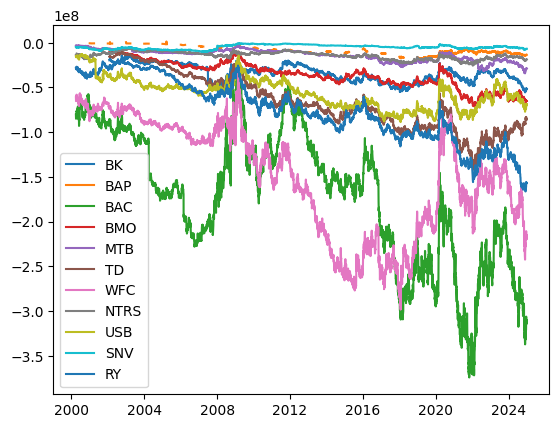

In [62]:
# plot all keys of Georisk_dict on the same plot and  the geo index with silver colour in another one below

# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
for ticker in Georisk_dict.keys():
    plt.plot(Georisk_dict[ticker], label=ticker)
    plt.legend()
# plt.subplot(2, 1, 2)
# plt.plot(Geo_Pol_index, color='silver', label='Geo-Political Index')
# plt.legend()
    

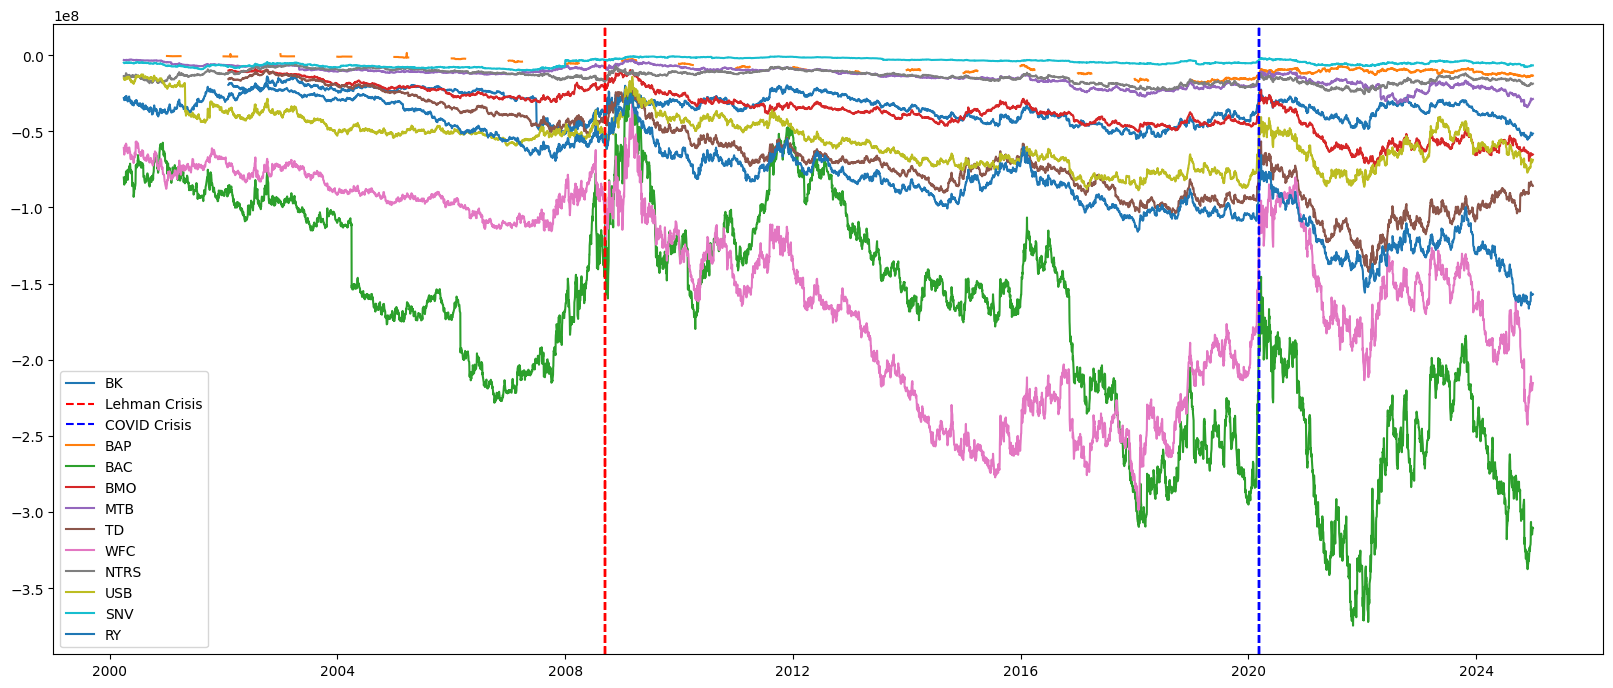

In [68]:

lehman_crisis = pd.to_datetime('2008-09-15')
COVID_crisis = pd.to_datetime('2020-03-11')
plt.figure(figsize=(20, 18))
plt.subplot(2, 1, 1)

for ticker, y in Georisk_dict.items():
    plt.plot(y, label=ticker)
    plt.axvline(x=lehman_crisis, color='red', linestyle='--', label='Lehman Crisis' if ticker == list(Georisk_dict.keys())[0] else "")
    plt.axvline(x=COVID_crisis, color='blue', linestyle='--', label='COVID Crisis' if ticker == list(Georisk_dict.keys())[0] else "")
    plt.legend()


    

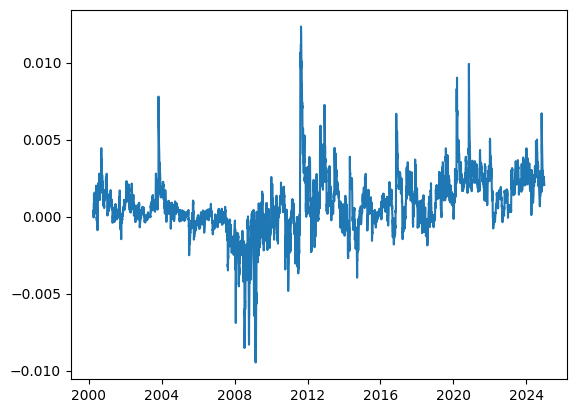

In [58]:
plt.plot(beta_i_geo['BAC'])

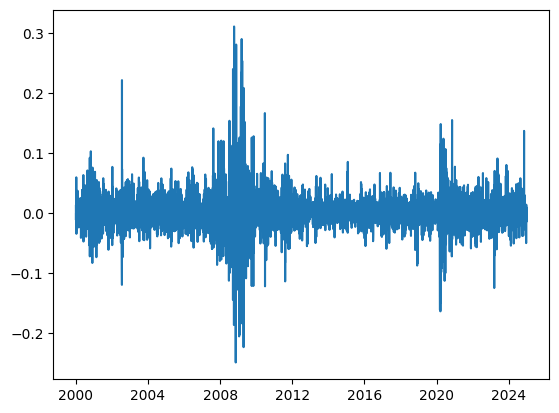

In [55]:
plt.plot(Bank_data_other['ABCB']['RET'])

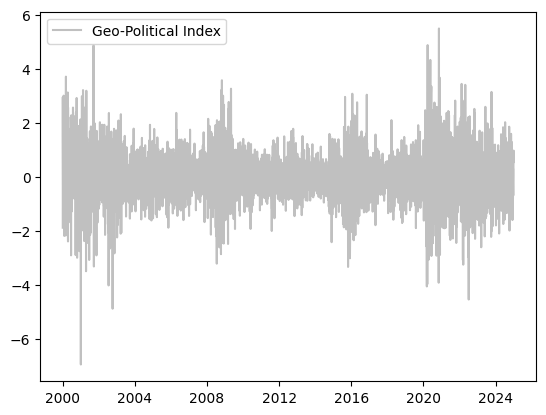

In [ ]:
# plt.subplot(2, 1, 2)
plt.plot(Geo_Pol_index, color='silver', label='Geo-Political Index')
plt.legend()

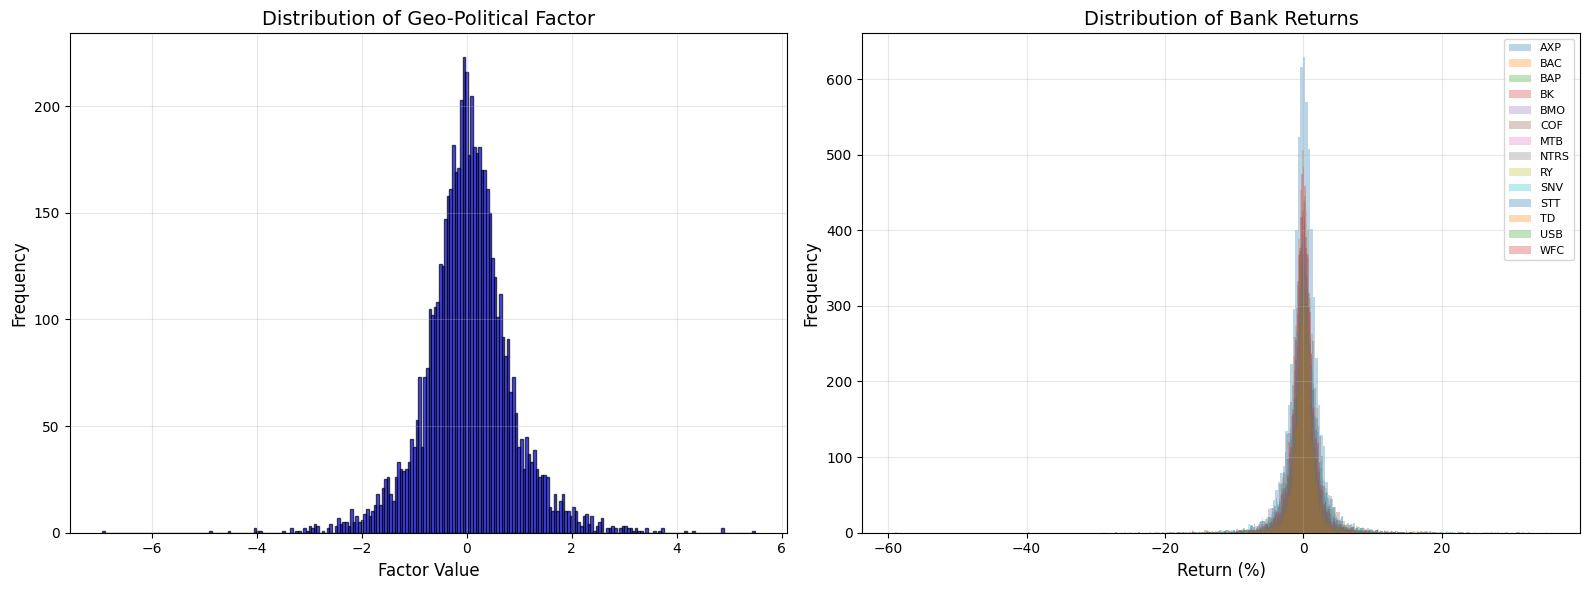

In [104]:
# Plot distribution of Geo_Pol_index & on the side plot returns of banks
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Distribution of Geo_Pol_index
axes[0].hist(Geo_Pol_index[0].dropna(), bins=250, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Distribution of Geo-Political Factor', fontsize=14)
axes[0].set_xlabel('Factor Value', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Right plot: Distribution of bank returns
axes[1].set_title('Distribution of Bank Returns', fontsize=14)
axes[1].set_xlabel('Return (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

for ticker in Bank_data_filtered.keys():
    returns = Bank_data_filtered[ticker]['RET'] * 100  # Convert to percentage
    axes[1].hist(returns.dropna(), bins=250, alpha=0.3, label=ticker)

axes[1].legend(loc='upper right', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

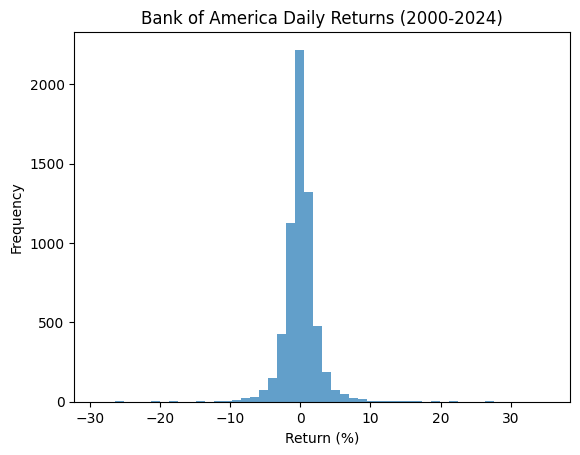

In [130]:
plt.hist(Bank_data_filtered['BAC']['RET']*100,
         bins = 50,
         alpha=0.7,)
plt.title('Bank of America Daily Returns (2000-2024)')
plt.ylabel('Frequency')
plt.xlabel('Return (%)')
plt.show()

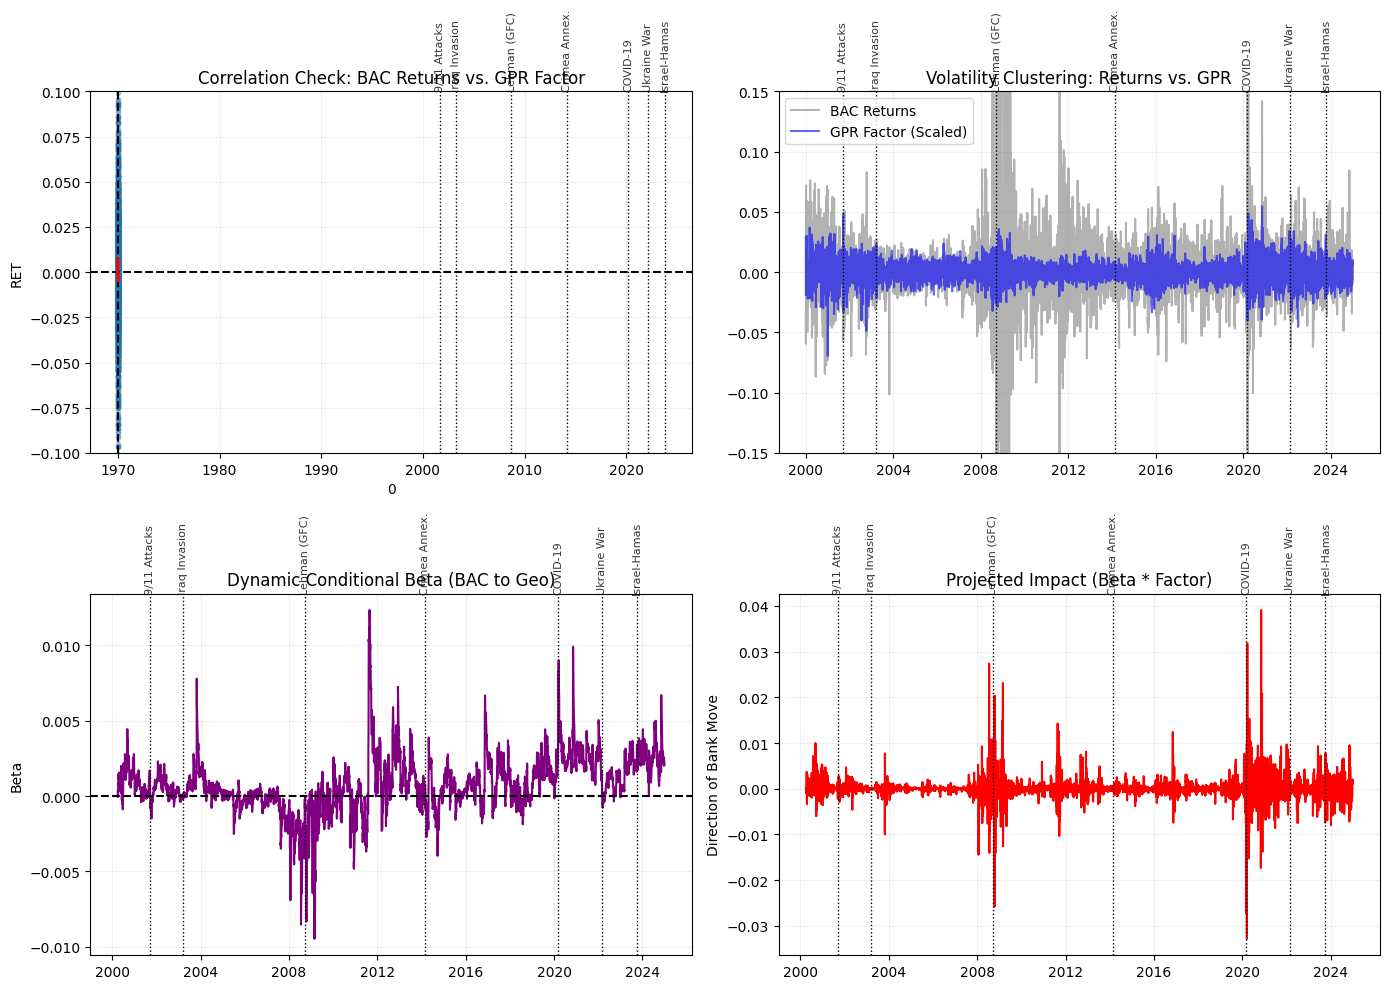

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

events = {
    '9/11 Attacks': '2001-09-11',
    'Iraq Invasion': '2003-03-20',
    'Lehman (GFC)': '2008-09-15',
    'Crimea Annex.': '2014-02-20',
    'COVID-19': '2020-03-11',
    'Ukraine War': '2022-02-24',
    'Israel-Hamas': '2023-10-07'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax1, ax2, ax3, ax4 = axes.flatten() # Flattens 2x2 into a list of 4

ax_list = [ax1, ax2, ax3, ax4]

ax1.scatter(Geo_Pol_index, Bank_data_filtered['BAC']['RET'], alpha=0.3, s=10)
ax1.set_title('Correlation Check: BAC Returns vs. GPR Factor')
ax1.set_xlabel('Geopolitical Factor (Long Def/Energy)')
ax1.set_ylabel('BAC Daily Return')
ax1.set_ylim(-0.1, 0.1)
ax1.axhline(0, color='black', linestyle='--')
ax1.axvline(0, color='black', linestyle='--')
sns.regplot(x=Geo_Pol_index, y=Bank_data_filtered['BAC']['RET'], ax=ax1, scatter=False, color='red')

ax2.plot(Bank_data_filtered['BAC']['RET'], label='BAC Returns', alpha=0.6, color='grey')
ax2.plot(Geo_Pol_index/100, label='GPR Factor (Scaled)', color='blue', alpha=0.6) # Scale for visibility
ax2.set_title('Volatility Clustering: Returns vs. GPR')
ax2.set_ylim(-0.15, 0.15) # change y scale to be able to see if tracking goes up for GEOPOL and not financial crisis of 2008
ax2.legend()

ax3.plot(beta_i_geo['BAC'], color='purple')
ax3.set_title('Dynamic Conditional Beta (BAC to Geo)')
ax3.axhline(0, color='black', linestyle='--')
ax3.set_ylabel('Beta')

interaction = beta_i_geo['BAC'] * Geo_Pol_index
ax4.plot(interaction, color='red')
ax4.set_title('Projected Impact (Beta * Factor)')
ax4.set_ylabel('Direction of Bank Move')

for ax in ax_list:
    ax.grid(True, alpha=0.2)
    
    for label, date_str in events.items():
        event_date = pd.to_datetime(date_str)
        
        ax.axvline(x=event_date, color='black', linestyle=':', alpha=1, linewidth=1)
        
        ylim = ax.get_ylim()
        ax.text(x=event_date, y=ylim[1], s=label, 
                rotation=90, verticalalignment='bottom', horizontalalignment='center',
                fontsize=8, color='black', alpha=0.8)

plt.tight_layout()
plt.show()

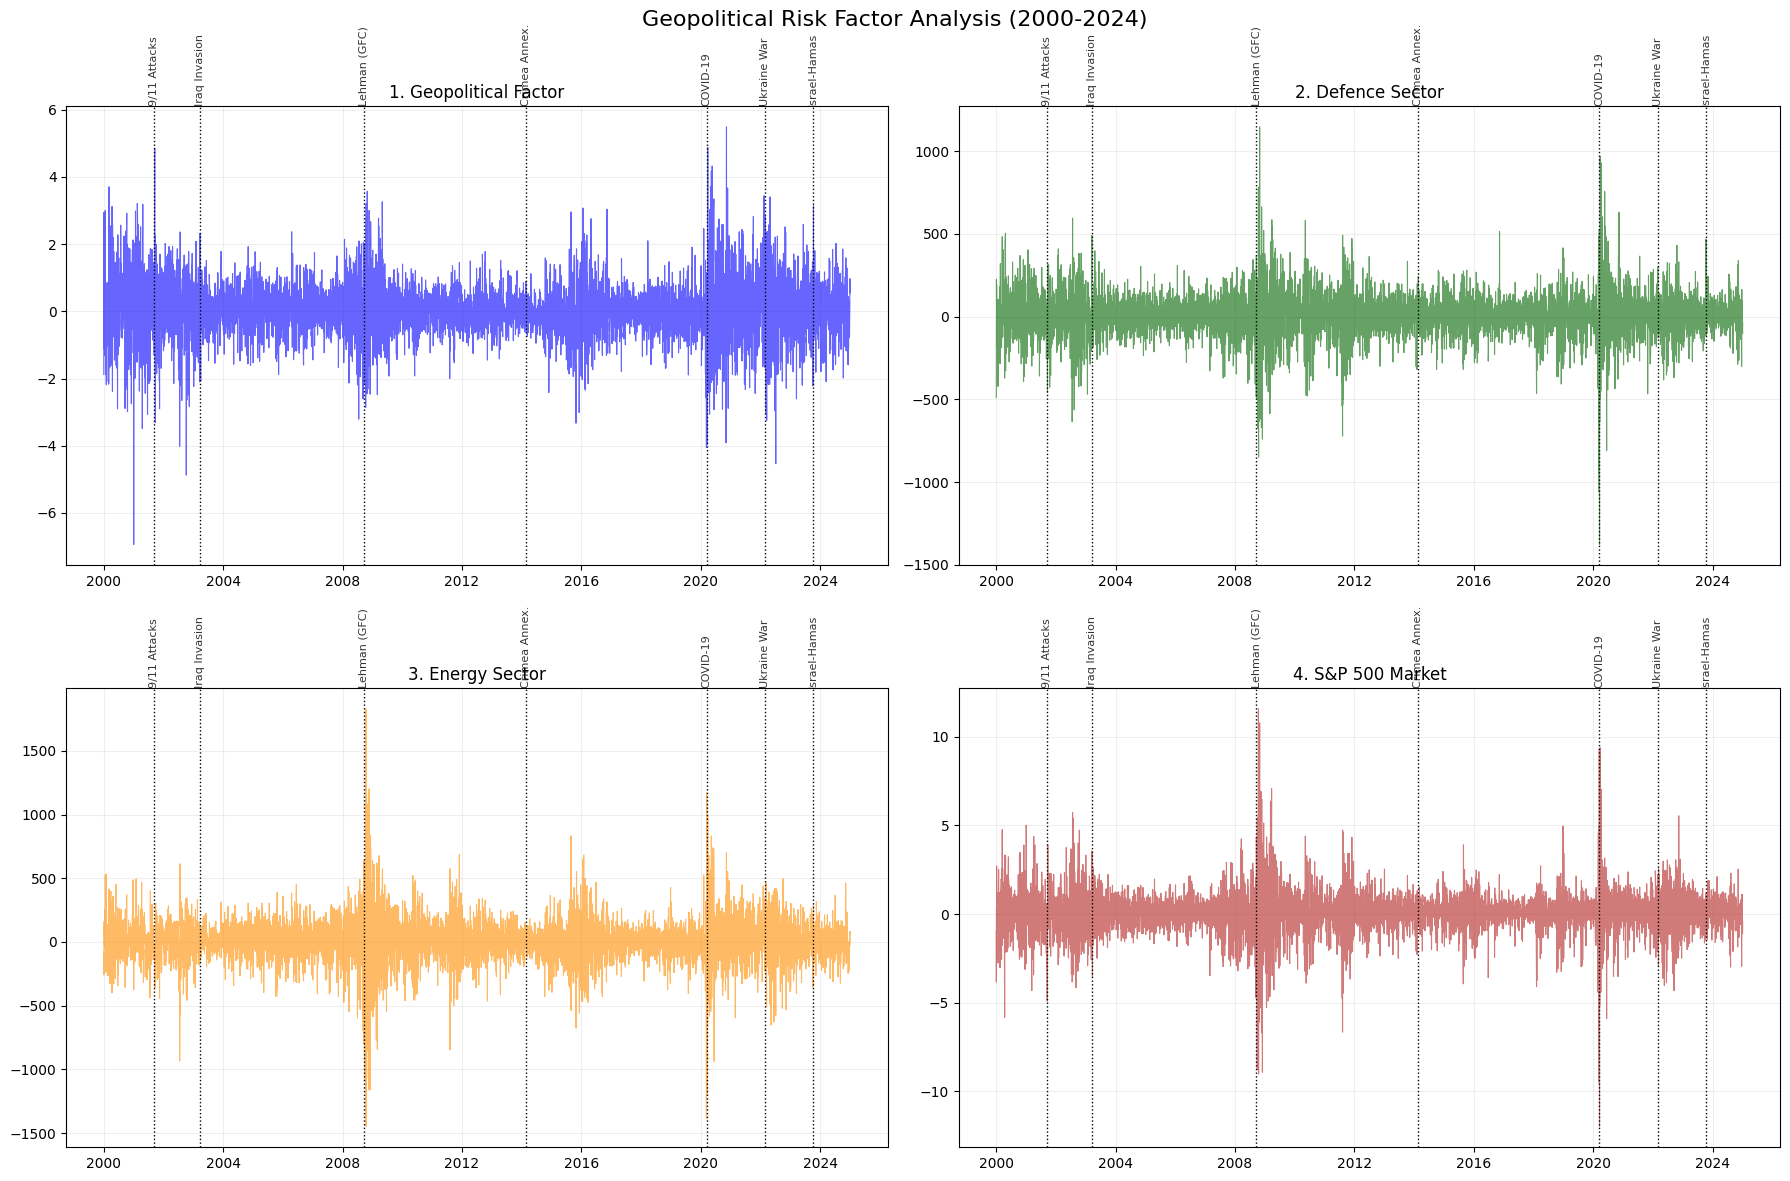

In [ ]:


# Now run your plotting code exactly as before
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Geopolitical Risk Factor Analysis (2000-2024)', fontsize=16)

ax_list = axes.flatten()

# Plot Data
ax_list[0].plot(Geo_Pol_index, color='blue', linewidth=0.8, alpha = 0.6)
ax_list[0].set_title('1. Geopolitical Factor')

ax_list[1].plot(Defence_index * 100, color='darkgreen', linewidth=0.8, alpha = 0.6)
ax_list[1].set_title('2. Defence Sector')

ax_list[2].plot(Energy_index * 100, color='darkorange', linewidth=0.8, alpha = 0.6)
ax_list[2].set_title('3. Energy Sector')

SP_index.index = pd.to_datetime(SP_index.index, errors='coerce')
ax_list[3].plot(SP_index * 100, color='firebrick', linewidth=0.8, alpha = 0.6)
ax_list[3].set_title('4. S&P 500 Market')

# Overlay Loop
for ax in ax_list:
    ax.grid(True, alpha=0.2)
    
    for label, date_str in events.items():
        event_date = pd.to_datetime(date_str)
        
        ax.axvline(x=event_date, color='black', linestyle=':', alpha=1, linewidth=1)
        
        ylim = ax.get_ylim()
        ax.text(x=event_date, y=ylim[1], s=label, 
                rotation=90, verticalalignment='bottom', horizontalalignment='center',
                fontsize=8, color='black', alpha=0.8)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
target_ticker = 'BAC'

#  Get the Shortfall (GeoRISK) Series
if target_ticker in Georisk_dict:
    shortfall_series = Georisk_dict[target_ticker]
else:
    print(f"Error: {target_ticker} not found in Georisk_dict. Please run the calculation loop first.")
    shortfall_series = pd.Series(dtype=float)

#  Get the Dynamic Beta
# We need to pull this from your model results. 
# If you don't have a beta_dict, we can quickly re-extract it from the 'models' dict you created earlier
# or from the 'beta_i_geo' dataframe if you made one.
# Here I assume 'beta_i_geo' exists (as seen in your previous snippet).
if 'beta_i_geo' in globals() and target_ticker in beta_i_geo:
    beta_series = beta_i_geo[target_ticker]
else:
    # Fallback: Create dummy beta if variable missing (Replace with your actual beta variable)
    print("Warning: beta_i_geo not found. Using placeholder.")
    beta_series = pd.Series(0, index=shortfall_series.index)

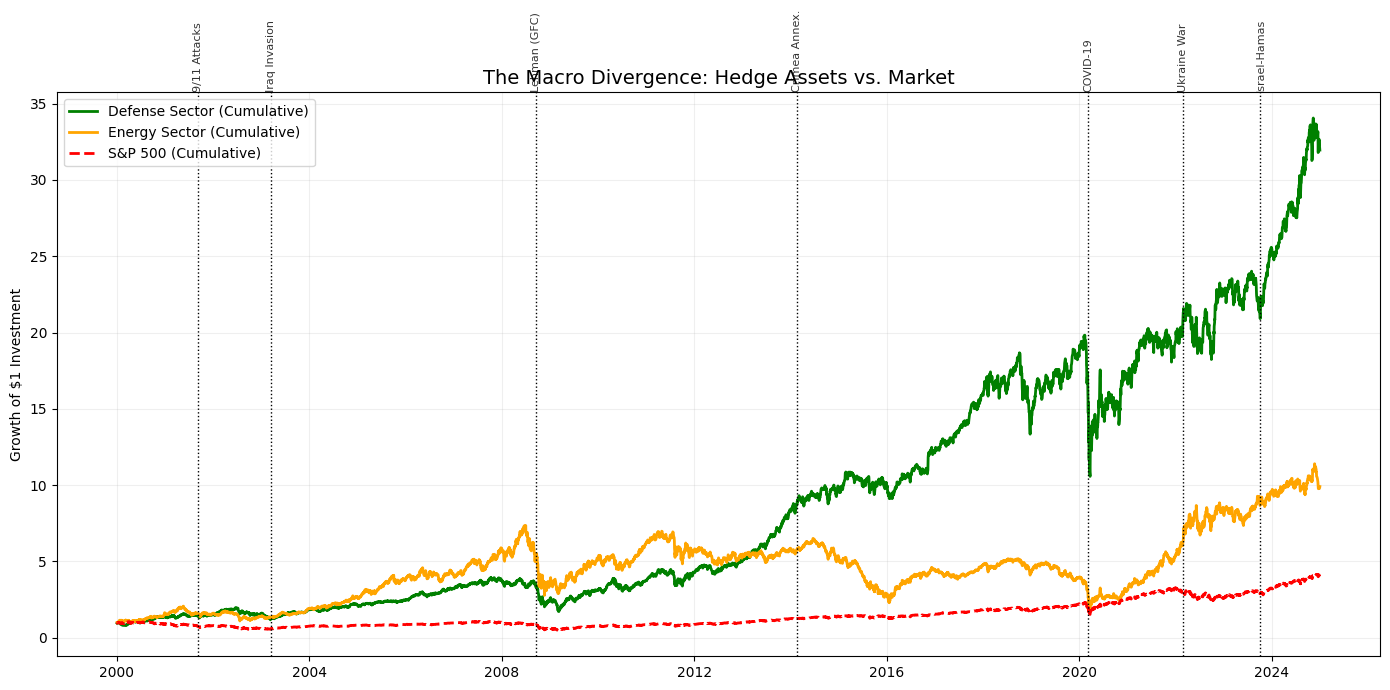

In [ ]:

ukraine = pd.to_datetime('2022-02-24')
cum_def = (1 + Defence_index/100).cumprod()
cum_nrg = (1 + Energy_index/100).cumprod()
cum_mkt = (1 + SP_index).cumprod()

# For the Factor, we cumulate the long-short spread
cum_factor = (1 + Geo_Pol_index/100).cumprod() 

fig, ax1 = plt.subplots(figsize=(14, 7))

# 1. Plot the Components (Left Axis)
ax1.plot(cum_def, color='green', linewidth=2, label='Defense Sector (Cumulative)')
ax1.plot(cum_nrg, color='orange', linewidth=2, label='Energy Sector (Cumulative)')
ax1.plot(cum_mkt, color='red', linewidth=2, linestyle='--', label='S&P 500 (Cumulative)')

ax1.set_title('The Macro Divergence: Hedge Assets vs. Market', fontsize=14)
ax1.set_ylabel('Growth of $1 Investment')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

ax1.grid(True, alpha=0.2)

for label, date_str in events.items():
    event_date = pd.to_datetime(date_str)
    
    ax1.axvline(x=event_date, color='black', linestyle=':', alpha=1, linewidth=1)
    
    ylim = ax1.get_ylim()
    ax1.text(x=event_date, y=ylim[1], s=label, 
            rotation=90, verticalalignment='bottom', horizontalalignment='center',
            fontsize=8, color='black', alpha=0.8)

plt.tight_layout()

plt.show()

In [174]:
dashboard_dict['BAC']['Book Leverage']*0.08

datadate
2000-03-31    15747.28
2000-06-30    17098.72
2000-09-30    16229.12
2000-12-31    13128.88
2001-03-31    11622.08
                ...   
2024-12-31    53405.04
2025-03-31    58470.56
2025-06-30    61572.88
2025-09-30    57378.16
2025-12-31    56849.60
Name: Book Leverage, Length: 104, dtype: float64

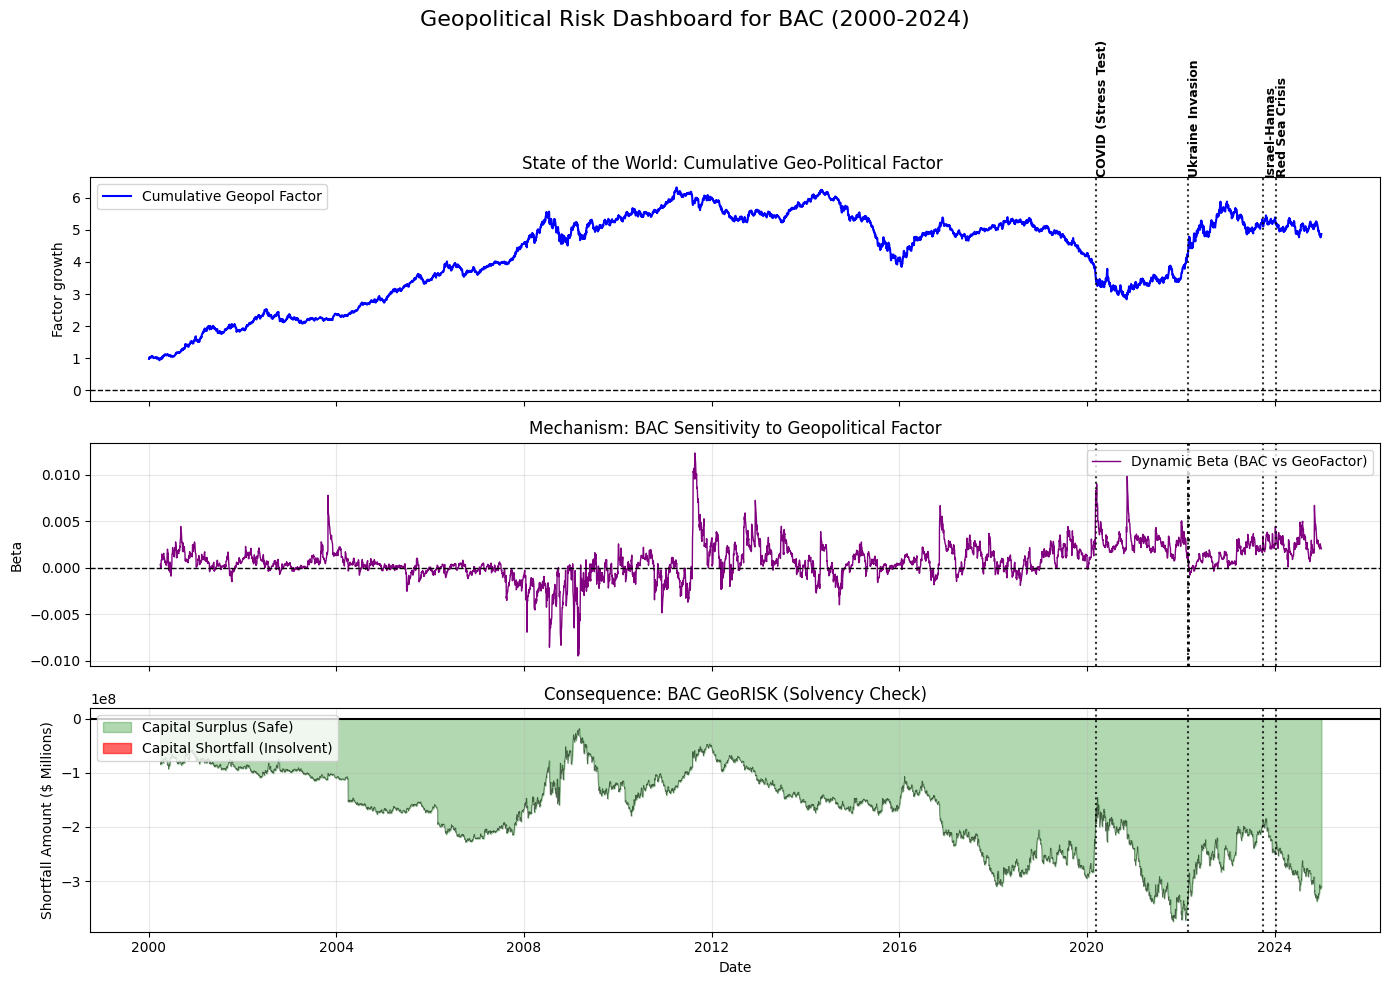

In [182]:
import matplotlib.dates as mdates

recent_conflicts = {
    'COVID (Stress Test)': '2020-03-11',  # Control Variable (Market Crash, not War)
    'Ukraine Invasion': '2022-02-24',     # Major Geopolitical Event
    'Israel-Hamas': '2023-10-07',         # Middle East Tension
    'Red Sea Crisis': '2024-01-12'        # Trade/Energy Disruption (Houthi Strikes)
}

fig, (ax_factor,ax_beta, ax_risk) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

plt.suptitle(f'Geopolitical Risk Dashboard for {target_ticker} (2000-2024)', fontsize=16)

# --- Panel 1: The state of the world(GPR factor) ---
geo_cum = (1 + Geo_Pol_index/100).cumprod()
ax_factor.plot(geo_cum, color='blue', linewidth=1.5, label='Cumulative Geopol Factor')
ax_factor.axhline(0, color='black', linestyle='--', linewidth=1)
ax_factor.set_title('State of the World: Cumulative Geo-Political Factor ', fontsize=12)
ax_factor.set_ylabel('Factor growth')
ax_factor.legend(loc='upper left')

# --- Panel 2: The Mechanism (Dynamic Conditional Beta) ---
ax_beta.plot(beta_series, color='purple', linewidth=1, label=f'Dynamic Beta ({target_ticker} vs GeoFactor)')
ax_beta.axhline(0, color='black', linestyle='--', linewidth=1)

# Style
ax_beta.set_title(f'Mechanism: {target_ticker} Sensitivity to Geopolitical Factor', fontsize=12)
ax_beta.set_ylabel('Beta')
ax_beta.legend(loc='upper right')
ax_beta.grid(True, alpha=0.3)
ax_beta.axvline(x=ukraine, color='black', linestyle=':', linewidth=2)


# --- Panel 3: The Consequence (Capital Shortfall / Solvency) ---
# We use fill_between to create the "Waterline" effect
# Values < 0 are SURPLUS (Safe/Green)
# Values > 0 are SHORTFALL (Insolvent/Red)

ax_risk.plot(shortfall_series, color='black', linewidth=0.5, alpha=0.5)

# Fill Surplus (Green)
ax_risk.fill_between(shortfall_series.index, 0, shortfall_series, 
                     where=(shortfall_series <= 0), 
                     color='green', alpha=0.3, label='Capital Surplus (Safe)')

# Fill Shortfall (Red)
ax_risk.fill_between(shortfall_series.index, 0, shortfall_series, 
                     where=(shortfall_series > 0), 
                     color='red', alpha=0.6, label='Capital Shortfall (Insolvent)')

ax_risk.axhline(0, color='black', linewidth=1.5) # The Waterline

# Style
ax_risk.set_title(f'Consequence: {target_ticker} GeoRISK (Solvency Check)', fontsize=12)
ax_risk.set_ylabel('Shortfall Amount ($ Millions)')
ax_risk.legend(loc='upper left')
ax_risk.grid(True, alpha=0.3)


#ax_risk.axvline(x=ukraine, color='black', linestyle=':', linewidth=2)


for ax in [ax_factor, ax_beta, ax_risk]:
    for name, date_str in recent_conflicts.items():
        date_obj = pd.to_datetime(date_str)
        
        # Draw Line
        ax.axvline(x=date_obj, color='black', linestyle=':', linewidth=1.5, alpha=0.8)
        
        # Add Label ONLY to the top graph to avoid clutter
        if ax == ax_factor:
            ylim = ax.get_ylim()
            ax.text(x=date_obj, y=ylim[1], s=name, 
                    rotation=90, verticalalignment='bottom', 
                    fontsize=9, fontweight='bold', color='black')


# Look at periods with GEO political tension
#start_zoom = pd.to_datetime('2019-01-01')
#end_zoom = pd.to_datetime('2024-12-31')
#ax_risk.set_xlim(start_zoom, end_zoom)


# Formatting Date Axis
plt.xlabel('Date')
plt.tight_layout()
plt.show()